In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [20]:
from tensorflow.keras.preprocessing import image_dataset_from_directory, image

train_directory = r'../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
valid_directory = r'../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

train_dataset = image_dataset_from_directory(train_directory,
                                            seed = 2059,
                                            image_size = (224, 224),
                                            batch_size = 16,
                                            label_mode = 'int')


valid_dataset = image_dataset_from_directory(valid_directory,
                                            seed = 2059,
                                            image_size = (224, 224),
                                            batch_size = 16,
                                            label_mode = 'int')

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


In [21]:
labels = train_dataset.class_names
print(len(labels))

2


In [22]:
labels

['WithMask', 'WithoutMask']

In [23]:
from tensorflow.keras.applications.resnet import ResNet50

base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

In [24]:
model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())

model.add(Dropout(0.2))

model.add(Dense(len(labels), activation = 'softmax'))

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [26]:
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

checkpoint = ModelCheckpoint("./ResNet50MaskDetector.h5",
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          mode = 'min',
                          restore_best_weights = True,
                          patience = 10,  
                          verbose = 1)

rlrp = ReduceLROnPlateau(monitor = 'val_loss',
                         mode = 'min',
                         factor = 0.5,
                         min_lr = 1e-6,
                         patience = 5)

callbacks = [earlystop, checkpoint, rlrp]

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [27]:
epochs = 20

history = model.fit(
    train_dataset,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = valid_dataset)

Epoch 1/20
625/625 [==============================] - 28s 41ms/step - loss: 0.0329 - accuracy: 0.9880 - val_loss: 0.0061 - val_accuracy: 0.9975

Epoch 00001: val_loss improved from inf to 0.00608, saving model to ./ResNet50MaskDetector.h5
Epoch 2/20
625/625 [==============================] - 25s 40ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.0038 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.00608 to 0.00382, saving model to ./ResNet50MaskDetector.h5
Epoch 3/20
625/625 [==============================] - 25s 40ms/step - loss: 0.0062 - accuracy: 0.9978 - val_loss: 0.0017 - val_accuracy: 0.9987

Epoch 00003: val_loss improved from 0.00382 to 0.00169, saving model to ./ResNet50MaskDetector.h5
Epoch 4/20
625/625 [==============================] - 25s 39ms/step - loss: 0.0023 - accuracy: 0.9990 - val_loss: 0.0023 - val_accuracy: 0.9987

Epoch 00004: val_loss did not improve from 0.00169
Epoch 5/20
625/625 [==============================] - 25s 39ms/step - loss: 0.0

In [28]:
history_df = pd.DataFrame(history.history)

In [29]:
history_df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.032870,0.9880,0.006075,0.99750,0.001
1,0.006612,0.9979,0.003816,1.00000,0.001
2,0.006189,0.9978,0.001687,0.99875,0.001
3,0.002319,0.9990,0.002305,0.99875,0.001
4,0.001816,0.9990,0.004306,0.99750,0.001


<AxesSubplot:>

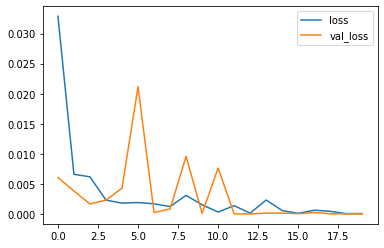

In [30]:
history_df.loc[: , ['loss', 'val_loss']].plot()

<AxesSubplot:>

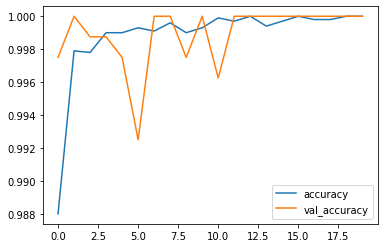

In [31]:
(history_df.loc[: , ['accuracy', 'val_accuracy']]).plot()

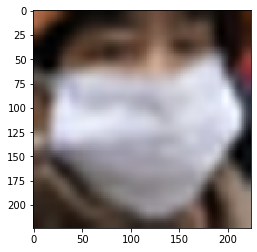

In [33]:
path = r'../input/face-mask-detection/Dataset/with_mask/1005.png'

img = image.load_img(path, target_size = (224, 224, 3))

plt.imshow(img)

img = image.img_to_array(img)

img = np.expand_dims(img, axis = 0)

pred = model.predict(img)

In [34]:
label = np.argmax(pred)

In [35]:
labels[label]

'WithMask'

In [36]:
test_directory = r'../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'

test_dataset = image_dataset_from_directory(test_directory,
                                            seed = 2059,
                                            image_size = (224, 224),
                                            batch_size = 16,
                                            label_mode = 'int')

Found 992 files belonging to 2 classes.


In [37]:
score = model.evaluate(test_dataset)
score

62/62 [==============================] - 7s 101ms/step - loss: 0.0314 - accuracy: 0.9970


[0.031417910009622574, 0.9969757795333862]